In [1]:
import time
from absl import app, logging
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
%run 'yolov3_tf2.ipynb'

In [3]:
%run 'utils.ipynb'

In [41]:
classFile = './data/classes.txt'
weights = './data/yolov3_train_50.tf'
size = 416
image = './data/host-a004_cam0_1232815252251064006.jpeg'
tfrecord =  None#'./data/audi_test.tfrecord'
output = './output.jpg'
num_classes = 14


def detect():
    
    yolo = YoloV3(classes=num_classes)

    yolo.load_weights(weights).expect_partial()
    logging.info('weights loaded')

    class_names = [c.strip() for c in open(classFile).readlines()]
    logging.info('classes loaded')

    if tfrecord:
        dataset = load_tfrecord_dataset(
            tfrecord, classFile, size)
        dataset = dataset.shuffle(512)
        img_raw, _label = next(iter(dataset.take(1)))
    else:
        img_raw = tf.image.decode_image(
            open(image, 'rb').read(), channels=3)

    img = tf.expand_dims(img_raw, 0)
    img = transform_images(img, size)

    t1 = time.time()
    boxes, scores, classes, nums = yolo(img)
    t2 = time.time()
    logging.info('time: {}'.format(t2 - t1))

    logging.info('detections:')
    for i in range(nums[0]):
        logging.info('\t{}, {}, {}'.format(class_names[int(classes[0][i])],
                                           np.array(scores[0][i]),
                                           np.array(boxes[0][i])))

    img = cv2.cvtColor(img_raw.numpy(), cv2.COLOR_RGB2BGR)
        
    img = draw_outputs(img, (boxes, scores, classes, nums), class_names)
    
    cv2.imwrite(output, img)
    fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,15))
    plt.imshow(img)
    logging.info('output saved to: {}'.format(output))

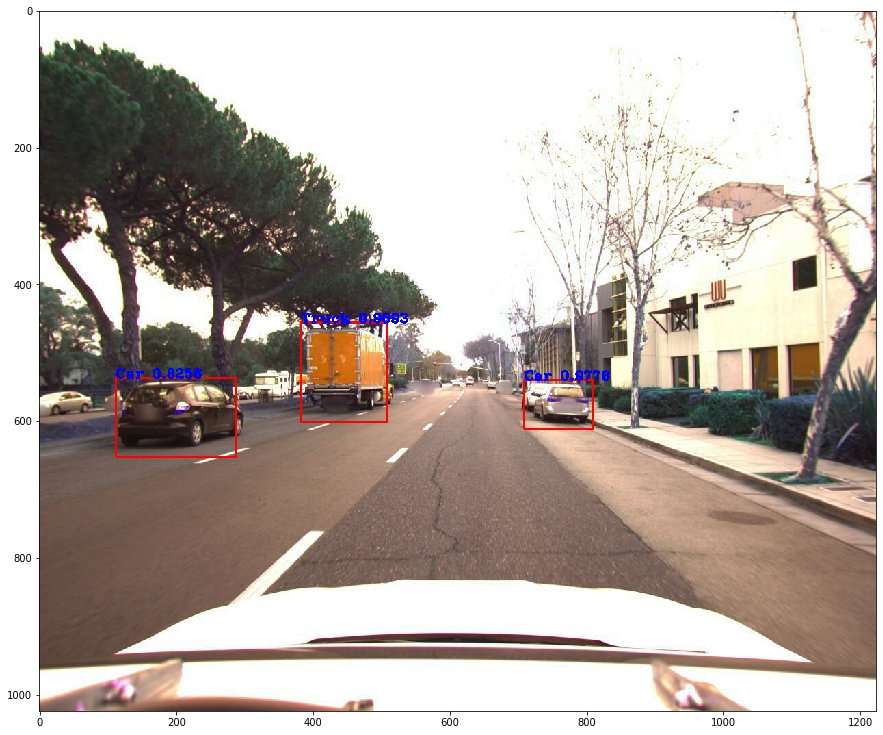

In [42]:
detect()